In this notebook, we'll visualize the uncertainty of the **shooting range of a cannon** by using a visualization technique called Hypothetical Outcome Plots

Towards that end, we'll create an animation that cycles through different possible cannonball trajectories

In [1]:
!pip install celluloid

In [2]:
# Import libraries and set plots to be embedded inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from celluloid import Camera

from pylab import rcParams
rcParams['figure.figsize'] = 14,8

%matplotlib inline
np.set_printoptions(precision=2, suppress=True)
np.random.seed(43)

import warnings
warnings.filterwarnings('ignore')

##Problem settings
### Physical background
We consider a projectile motion problem, and we are interested in computing the shooting range $R$ of a cannon. For demonstration purpose, we choose a rather simple physical model to describe the trajectary of the cannonball, where the shooting range $R$ is calculated by:

\begin{equation}
R = \frac{v_0^2 sin 2 \theta}{g},
\end{equation}

where $v_0$ is the initial velocity of the cannonball, $\theta$ is the shooting angle, and $g=9.8m/s^2$ is the gravity acceleration. An illustration of the current problem is shown below

<img src="./assets/Cannon_Illustration.png" width=500 height=300 />

### Uncertainty analysis
Suppose that we are not sure about the values of $v_0$ and $\theta$, as they can be influenced by randomness in practice. To describe their uncertainty, we assign a probability distribution for $v_0$ and $\theta$, respectively 

Specifically, we assume:

* **$v_0$ follows a normal distribution**, i.e., $v_0 \sim \mathcal{N}(150,5^2)$. This distribution indicates that the mean value of $v_0$ is $150m/s$ and the standard deviation value of $v_0$ is $5m/s$

* **$\theta$ follows a uniform distribution**, i.e., $\theta \sim \mathcal{U}(40,50)$. This distribution indicates that $\theta$ can take any value between $40^{o}$ and $50^{o}$ with equal probability

Due to the uncertainty embedded in the model parameters ($v_0$ and $\theta$), the prediction of shooting range $R$ will also be uncertain. To quantify the uncertainty of $R$ computation, we can perform Monte Carlo simulations 

###1. Monte Carlo simulations
First of all, let's perform Monte Carlo simulations to quantify the uncertainty of $R$ computations

In [3]:
# Generate input samples
MC_sample_num = 1000
v0 = np.random.normal(loc=150, scale=5, size=MC_sample_num)
theta = 10*np.random.rand(MC_sample_num)+40
g = 9.8

In [4]:
# Monte Carlo simulations
R = []
for i in range(MC_sample_num):
    R.append(v0[i]**2*np.sin(2*theta[i]/180*np.pi)/g)

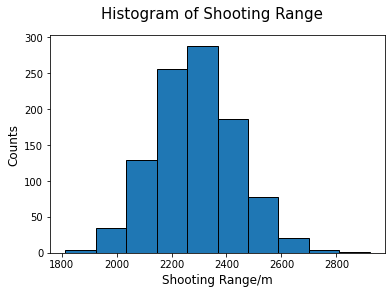

In [5]:
# Post processing
fig, ax = plt.subplots()
n, bins, patches = ax.hist(
    R, 
    bins=10, 
    edgecolor='black'
)

hist_bottom, hist_top = ax.get_ylim()
fig.suptitle('Histogram of Shooting Range', fontsize=15)
ax.set_xlabel('Shooting Range/m', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)
plt.savefig('Cannon_histogram')

Here, we've plotted the histogram of $R$ to quantify the uncertainty in shooting range computations

>Using a Histogram is the standard way to display data distribution 

However, it's boring as it's static. We can make our uncertainty presentation more alive by using HOPs

###2. Hypothetical outcome plots
We'll create an animation, where each frame demonstrates one possible cannonball trajectory given our uncertainty on $v_0$ and $\theta$ 

In [6]:
# Define trajectory computation function
def traj_cal(v0, theta, g, time_step=10):
    '''Calculate the cannonball trajectory
    Inputs:
        v0 --> initial velocity of the cannonball
        theta --> shooting angle (in degree)
        g --> gravity acceleration
        time_step --> time discretization
    Outputs:
        coor_X --> X coordinates of the cannonball
        coor_Y --> Y coordinates of the cannonball
        R --> Shooting range
    '''
    
    # Time for the cannonball to reach maximum height
    t_c = v0*np.sin(theta/180*np.pi)/g
    
    # Time discretization
    t = np.linspace(
        start=0, 
        stop=2*t_c, 
        num=time_step
    )
    
    coor_X, coor_Y = [], []
    
    # Calculate trajectory
    for time in t:
        coor_X.append(v0*np.cos(theta/180*np.pi)*time)
        if time <= t_c:
            coor_Y.append(v0*np.sin(theta/180*np.pi)*time-0.5*g*time**2)
        else:
            coor_Y.append(v0*np.sin(theta/180*np.pi)*t_c-0.5*g*t_c**2-0.5*g*(time-t_c)**2)
    R = coor_X[-1]  
    
    return coor_X, coor_Y, R

In [7]:
# Trajectory computation settings
time_step = 20      # Time discretization
traj_num = 50       # Number of total trajectories
traj_X, traj_Y, Range = [], [], []

# Parameters
v0 = np.random.normal(loc=150, scale=5, size=MC_sample_num)
theta = 10*np.random.rand(MC_sample_num)+40
g = 9.8

for i in range(traj_num):
    coor_X, coor_Y, R= traj_cal(v0[i], theta[i], g, time_step)
    
    traj_X.append(coor_X)
    traj_Y.append(coor_Y)
    Range.append(R)

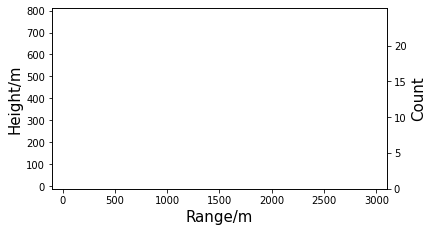

In [8]:
# Display trajectories in animation
fig = plt.figure()
ax_show = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax_hide = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1)
ax_rep = ax_show.twinx()

ax_show.set(xlim=(-100,3100), ylim=(-10,810))
ax_show.set_xlabel('Range/m', fontsize=15)
ax_show.set_ylabel('Height/m', fontsize=15)

# A work-around to prevent cropping the labels when saving gif
ax_hide.axis('off')

ax_rep.set_ylim(0,25.2)
ax_rep.set_yticks(list(range(0,25,5)))
ax_rep.set_ylabel('Count', fontsize=15)

# Initiate camera
camera = Camera(fig)

for i in range(traj_num):
    for j in range(time_step):
        
        # Add trajectory
        x = traj_X[i][0:j+1]
        y = traj_Y[i][0:j+1]
        ax_show.plot(x, y, color='b', lw=2, linestyle='--')
        ax_show.plot(x[-1], y[-1], marker='o', markersize=12, markeredgecolor='r', markerfacecolor='r')
        
        # Add histogram
        if i==0:
            if j==time_step-1:
                ax_rep.hist(Range[i], bins=bins, edgecolor=(1.0, 0.5, 0.25), fc=(1.0, 0.5, 0.25, 0.5))
        else:
            if j==time_step-1:
                ax_rep.hist(Range[0:i+1], bins=bins, edgecolor=(1.0, 0.5, 0.25), fc=(1.0, 0.5, 0.25, 0.5))
            else: 
                ax_rep.hist(Range[0:i], bins=bins, edgecolor=(1.0, 0.5, 0.25), fc=(1.0, 0.5, 0.25, 0.5))
        # Capture frame
        camera.snap()

anim = camera.animate(interval=40, repeat=False, repeat_delay=500)
#anim.save('Cannon_trajectory.gif', writer='imagemagick')

In [9]:
HTML(anim.to_html5_video())